In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt
from double_net import utils_misreport as utils


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1.0)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=0, rgt_start=0, rho=1.0, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='exact_one'
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
train_loop(model, train_loader, args, device=device)

  1%|          | 1/100 [01:02<1:42:35, 62.18s/it]

{'regret_max': 0.5448421835899353, 'regret_mean': 0.014919913373887539, 'regret_mults': tensor([[5.6158]], device='cuda:0'), 'payment': 0.05350997671484947}


  2%|▏         | 2/100 [02:04<1:41:27, 62.12s/it]

{'regret_max': 0.07554197311401367, 'regret_mean': 0.007496367208659649, 'regret_mults': tensor([[6.4041]], device='cuda:0'), 'payment': 0.06838853657245636}


  3%|▎         | 3/100 [03:04<1:39:28, 61.53s/it]

{'regret_max': 0.06872594356536865, 'regret_mean': 0.004851548932492733, 'regret_mults': tensor([[7.2028]], device='cuda:0'), 'payment': 0.06889524310827255}


  4%|▍         | 4/100 [04:06<1:38:34, 61.61s/it]

{'regret_max': 0.06494474411010742, 'regret_mean': 0.0036932299844920635, 'regret_mults': tensor([[8.7511]], device='cuda:0'), 'payment': 0.06306339800357819}


  5%|▌         | 5/100 [05:07<1:37:39, 61.68s/it]

{'regret_max': 0.06577491760253906, 'regret_mean': 0.003009591018781066, 'regret_mults': tensor([[9.7562]], device='cuda:0'), 'payment': 0.05929793417453766}


  6%|▌         | 6/100 [06:09<1:36:41, 61.72s/it]

{'regret_max': 0.06769436597824097, 'regret_mean': 0.0025565610267221928, 'regret_mults': tensor([[10.6038]], device='cuda:0'), 'payment': 0.05666133016347885}


  7%|▋         | 7/100 [07:11<1:35:39, 61.71s/it]

{'regret_max': 0.06303799152374268, 'regret_mean': 0.002321844920516014, 'regret_mults': tensor([[11.7176]], device='cuda:0'), 'payment': 0.05597596615552902}


  8%|▊         | 8/100 [08:13<1:34:38, 61.72s/it]

{'regret_max': 0.06947982311248779, 'regret_mean': 0.0021016979590058327, 'regret_mults': tensor([[14.0976]], device='cuda:0'), 'payment': 0.05408033728599548}


  9%|▉         | 9/100 [09:15<1:33:39, 61.76s/it]

{'regret_max': 0.05981945991516113, 'regret_mean': 0.0018566519720479846, 'regret_mults': tensor([[15.2707]], device='cuda:0'), 'payment': 0.05167841538786888}


 10%|█         | 10/100 [10:16<1:32:17, 61.53s/it]

{'regret_max': 0.06334161758422852, 'regret_mean': 0.001658886787481606, 'regret_mults': tensor([[16.6801]], device='cuda:0'), 'payment': 0.0492020808160305}


 11%|█         | 11/100 [11:17<1:31:20, 61.58s/it]

{'regret_max': 0.04988443851470947, 'regret_mean': 0.0017270066309720278, 'regret_mults': tensor([[19.1371]], device='cuda:0'), 'payment': 0.046969182789325714}


 12%|█▏        | 12/100 [12:18<1:30:09, 61.48s/it]

{'regret_max': 0.07934198528528214, 'regret_mean': 0.0018477715784683824, 'regret_mults': tensor([[20.2735]], device='cuda:0'), 'payment': 0.04661525785923004}


 13%|█▎        | 13/100 [13:20<1:29:00, 61.38s/it]

{'regret_max': 0.06959033012390137, 'regret_mean': 0.0014831733424216509, 'regret_mults': tensor([[21.4429]], device='cuda:0'), 'payment': 0.050614211708307266}


 14%|█▍        | 14/100 [14:21<1:27:48, 61.26s/it]

{'regret_max': 0.06317359954118729, 'regret_mean': 0.0015585469081997871, 'regret_mults': tensor([[22.7260]], device='cuda:0'), 'payment': 0.049711380153894424}


 15%|█▌        | 15/100 [15:22<1:26:47, 61.26s/it]

{'regret_max': 0.032569825649261475, 'regret_mean': 0.0011536688543856144, 'regret_mults': tensor([[25.1927]], device='cuda:0'), 'payment': 0.06229637563228607}


 16%|█▌        | 16/100 [16:23<1:25:39, 61.19s/it]

{'regret_max': 0.028680384159088135, 'regret_mean': 0.0010317449923604727, 'regret_mults': tensor([[26.5538]], device='cuda:0'), 'payment': 0.07111547887325287}


 17%|█▋        | 17/100 [17:24<1:24:37, 61.18s/it]

{'regret_max': 0.03239327669143677, 'regret_mean': 0.0010338773718103766, 'regret_mults': tensor([[27.5428]], device='cuda:0'), 'payment': 0.07373440265655518}


 18%|█▊        | 18/100 [18:25<1:23:41, 61.24s/it]

{'regret_max': 0.022810399532318115, 'regret_mean': 0.0006885561742819846, 'regret_mults': tensor([[28.8953]], device='cuda:0'), 'payment': 0.07362082600593567}


 19%|█▉        | 19/100 [19:27<1:22:46, 61.31s/it]

{'regret_max': 0.04566701501607895, 'regret_mean': 0.0008238428272306919, 'regret_mults': tensor([[29.3073]], device='cuda:0'), 'payment': 0.0719233974814415}


 20%|██        | 20/100 [20:29<1:22:14, 61.69s/it]

{'regret_max': 0.01254349946975708, 'regret_mean': 0.0004638347600121051, 'regret_mults': tensor([[29.8363]], device='cuda:0'), 'payment': 0.07501288503408432}


 21%|██        | 21/100 [21:32<1:21:28, 61.87s/it]

{'regret_max': 0.022574707865715027, 'regret_mean': 0.0004693996743299067, 'regret_mults': tensor([[30.2310]], device='cuda:0'), 'payment': 0.0742216408252716}


 22%|██▏       | 22/100 [22:34<1:20:24, 61.85s/it]

{'regret_max': 0.03442365676164627, 'regret_mean': 0.000621240702457726, 'regret_mults': tensor([[33.5474]], device='cuda:0'), 'payment': 0.07217845320701599}


 23%|██▎       | 23/100 [23:35<1:19:20, 61.82s/it]

{'regret_max': 0.012443289160728455, 'regret_mean': 0.00032866408582776785, 'regret_mults': tensor([[34.0947]], device='cuda:0'), 'payment': 0.07439667731523514}


 24%|██▍       | 24/100 [24:37<1:18:17, 61.81s/it]

{'regret_max': 0.009102821350097656, 'regret_mean': 0.0002678101882338524, 'regret_mults': tensor([[34.3562]], device='cuda:0'), 'payment': 0.07483957707881927}


 25%|██▌       | 25/100 [25:39<1:17:09, 61.73s/it]

{'regret_max': 0.008633121848106384, 'regret_mean': 0.00028030620887875557, 'regret_mults': tensor([[35.1843]], device='cuda:0'), 'payment': 0.07518038153648376}


 26%|██▌       | 26/100 [26:40<1:15:53, 61.54s/it]

{'regret_max': 0.030331134796142578, 'regret_mean': 0.0004594448546413332, 'regret_mults': tensor([[35.7245]], device='cuda:0'), 'payment': 0.07415200769901276}


 27%|██▋       | 27/100 [27:41<1:14:47, 61.48s/it]

{'regret_max': 0.008730962872505188, 'regret_mean': 0.00027496047550812364, 'regret_mults': tensor([[36.0104]], device='cuda:0'), 'payment': 0.07578229904174805}


 28%|██▊       | 28/100 [28:41<1:13:03, 60.88s/it]

{'regret_max': 0.012623876333236694, 'regret_mean': 0.00028534859302453697, 'regret_mults': tensor([[36.9362]], device='cuda:0'), 'payment': 0.07565270364284515}


 29%|██▉       | 29/100 [29:41<1:11:43, 60.61s/it]

{'regret_max': 0.010169029235839844, 'regret_mean': 0.0002472799096722156, 'regret_mults': tensor([[37.7988]], device='cuda:0'), 'payment': 0.07581323385238647}


 30%|███       | 30/100 [30:41<1:10:34, 60.50s/it]

{'regret_max': 0.01072704792022705, 'regret_mean': 0.00024266846594400704, 'regret_mults': tensor([[38.1782]], device='cuda:0'), 'payment': 0.0758093073964119}


 31%|███       | 31/100 [31:41<1:09:25, 60.36s/it]

{'regret_max': 0.01124235987663269, 'regret_mean': 0.00022241135593503714, 'regret_mults': tensor([[38.9180]], device='cuda:0'), 'payment': 0.07601740211248398}


 32%|███▏      | 32/100 [32:40<1:08:10, 60.15s/it]

{'regret_max': 0.03765365481376648, 'regret_mean': 0.0004259126144461334, 'regret_mults': tensor([[39.3327]], device='cuda:0'), 'payment': 0.07371150702238083}


 33%|███▎      | 33/100 [33:40<1:07:01, 60.02s/it]

{'regret_max': 0.010889321565628052, 'regret_mean': 0.00019422535842750221, 'regret_mults': tensor([[40.3001]], device='cuda:0'), 'payment': 0.0763869434595108}


 34%|███▍      | 34/100 [34:40<1:05:54, 59.92s/it]

{'regret_max': 0.013681530952453613, 'regret_mean': 0.00021402639686129987, 'regret_mults': tensor([[40.8911]], device='cuda:0'), 'payment': 0.07576403021812439}


 35%|███▌      | 35/100 [35:40<1:04:53, 59.90s/it]

{'regret_max': 0.010197758674621582, 'regret_mean': 0.0001811218389775604, 'regret_mults': tensor([[41.1904]], device='cuda:0'), 'payment': 0.07639491558074951}


 36%|███▌      | 36/100 [36:40<1:03:56, 59.95s/it]

{'regret_max': 0.01023167371749878, 'regret_mean': 0.00017564394511282444, 'regret_mults': tensor([[41.9622]], device='cuda:0'), 'payment': 0.07649485021829605}


 37%|███▋      | 37/100 [37:40<1:02:56, 59.94s/it]

{'regret_max': 0.010569363832473755, 'regret_mean': 0.00016851825057528913, 'regret_mults': tensor([[42.2986]], device='cuda:0'), 'payment': 0.07673780620098114}


 38%|███▊      | 38/100 [38:40<1:01:57, 59.96s/it]

{'regret_max': 0.01153707504272461, 'regret_mean': 0.00017251679673790932, 'regret_mults': tensor([[42.4988]], device='cuda:0'), 'payment': 0.07636014372110367}


 39%|███▉      | 39/100 [39:40<1:00:55, 59.92s/it]

{'regret_max': 0.012222900986671448, 'regret_mean': 0.00020370860875118524, 'regret_mults': tensor([[42.9720]], device='cuda:0'), 'payment': 0.07538701593875885}


 40%|████      | 40/100 [40:40<59:56, 59.94s/it]  

{'regret_max': 0.009954184293746948, 'regret_mean': 0.00016213682829402387, 'regret_mults': tensor([[43.5385]], device='cuda:0'), 'payment': 0.07650741934776306}


 41%|████      | 41/100 [41:40<58:58, 59.97s/it]

{'regret_max': 0.011876702308654785, 'regret_mean': 0.00015374275972135365, 'regret_mults': tensor([[43.8672]], device='cuda:0'), 'payment': 0.0765940248966217}


 42%|████▏     | 42/100 [42:39<57:54, 59.90s/it]

{'regret_max': 0.010365098714828491, 'regret_mean': 0.00014504232967738062, 'regret_mults': tensor([[44.1013]], device='cuda:0'), 'payment': 0.07671006768941879}


 43%|████▎     | 43/100 [43:39<56:51, 59.86s/it]

{'regret_max': 0.22050070762634277, 'regret_mean': 0.00207600649446249, 'regret_mults': tensor([[45.1160]], device='cuda:0'), 'payment': 0.042345080524683}


 44%|████▍     | 44/100 [44:39<55:51, 59.85s/it]

{'regret_max': 0.01950991153717041, 'regret_mean': 0.00011576704127946869, 'regret_mults': tensor([[45.4375]], device='cuda:0'), 'payment': 0.004210286773741245}


 45%|████▌     | 45/100 [45:39<54:56, 59.93s/it]

{'regret_max': 0.022148072719573975, 'regret_mean': 9.458266868023202e-05, 'regret_mults': tensor([[45.7039]], device='cuda:0'), 'payment': 0.006778357550501823}


 46%|████▌     | 46/100 [46:39<53:53, 59.88s/it]

{'regret_max': 0.025099098682403564, 'regret_mean': 0.00011971934145549312, 'regret_mults': tensor([[45.9984]], device='cuda:0'), 'payment': 0.009786034002900124}


 47%|████▋     | 47/100 [47:39<52:52, 59.85s/it]

{'regret_max': 0.027761995792388916, 'regret_mean': 0.00014378855121321976, 'regret_mults': tensor([[46.6494]], device='cuda:0'), 'payment': 0.0132143534719944}


 48%|████▊     | 48/100 [48:38<51:53, 59.87s/it]

{'regret_max': 0.029089689254760742, 'regret_mean': 0.0002017112128669396, 'regret_mults': tensor([[47.4445]], device='cuda:0'), 'payment': 0.017970556393265724}


 49%|████▉     | 49/100 [49:38<50:54, 59.89s/it]

{'regret_max': 0.028325378894805908, 'regret_mean': 0.00027967040659859776, 'regret_mults': tensor([[48.1950]], device='cuda:0'), 'payment': 0.02813814952969551}


 50%|█████     | 50/100 [50:39<49:57, 59.96s/it]

{'regret_max': 0.029782332479953766, 'regret_mean': 0.0004462618089746684, 'regret_mults': tensor([[52.7726]], device='cuda:0'), 'payment': 0.05100693553686142}


 51%|█████     | 51/100 [51:38<48:55, 59.91s/it]

{'regret_max': 0.08871698379516602, 'regret_mean': 0.0006393162184394896, 'regret_mults': tensor([[53.6226]], device='cuda:0'), 'payment': 0.02958049066364765}


 52%|█████▏    | 52/100 [52:38<47:53, 59.87s/it]

{'regret_max': 0.01980125904083252, 'regret_mean': 0.00026468391297385097, 'regret_mults': tensor([[54.4866]], device='cuda:0'), 'payment': 0.047705572098493576}


 53%|█████▎    | 53/100 [53:38<46:53, 59.86s/it]

{'regret_max': 0.022857367992401123, 'regret_mean': 0.00032010141876526177, 'regret_mults': tensor([[56.5597]], device='cuda:0'), 'payment': 0.06651842594146729}


 54%|█████▍    | 54/100 [54:38<45:52, 59.84s/it]

{'regret_max': 0.11728787422180176, 'regret_mean': 0.0010030149715021253, 'regret_mults': tensor([[63.9227]], device='cuda:0'), 'payment': 0.06635430455207825}


 55%|█████▌    | 55/100 [55:38<44:57, 59.94s/it]

{'regret_max': 0.03789806365966797, 'regret_mean': 0.00031692301854491234, 'regret_mults': tensor([[64.7229]], device='cuda:0'), 'payment': 0.03499557450413704}


 56%|█████▌    | 56/100 [56:38<43:56, 59.92s/it]

{'regret_max': 0.019431650638580322, 'regret_mean': 0.00015798318781889975, 'regret_mults': tensor([[65.3161]], device='cuda:0'), 'payment': 0.05818953365087509}


 57%|█████▋    | 57/100 [57:38<42:54, 59.87s/it]

{'regret_max': 0.020728856325149536, 'regret_mean': 0.00016390474047511816, 'regret_mults': tensor([[65.8178]], device='cuda:0'), 'payment': 0.06657283753156662}


 58%|█████▊    | 58/100 [58:37<41:53, 59.84s/it]

{'regret_max': 0.021056056022644043, 'regret_mean': 0.00016216313815675676, 'regret_mults': tensor([[66.7098]], device='cuda:0'), 'payment': 0.0708838552236557}


 59%|█████▉    | 59/100 [59:37<40:54, 59.86s/it]

{'regret_max': 0.030251994729042053, 'regret_mean': 0.0002679304452612996, 'regret_mults': tensor([[67.3420]], device='cuda:0'), 'payment': 0.07081586122512817}


 60%|██████    | 60/100 [1:00:37<39:57, 59.93s/it]

{'regret_max': 0.1836666464805603, 'regret_mean': 0.0012552659027278423, 'regret_mults': tensor([[69.7832]], device='cuda:0'), 'payment': 0.02289072796702385}


 61%|██████    | 61/100 [1:01:37<38:57, 59.94s/it]

{'regret_max': 0.015796244144439697, 'regret_mean': 0.00011100225674454123, 'regret_mults': tensor([[70.8280]], device='cuda:0'), 'payment': 0.028183814138174057}


 62%|██████▏   | 62/100 [1:02:37<37:55, 59.89s/it]

{'regret_max': 0.013637006282806396, 'regret_mean': 0.00020748535462189466, 'regret_mults': tensor([[72.3513]], device='cuda:0'), 'payment': 0.05728595703840256}


 63%|██████▎   | 63/100 [1:03:37<36:55, 59.89s/it]

{'regret_max': 0.0196683406829834, 'regret_mean': 0.00018737182836048305, 'regret_mults': tensor([[73.0096]], device='cuda:0'), 'payment': 0.06449129432439804}


 64%|██████▍   | 64/100 [1:04:37<35:55, 59.87s/it]

{'regret_max': 0.01481318473815918, 'regret_mean': 0.00018876895774155855, 'regret_mults': tensor([[73.7088]], device='cuda:0'), 'payment': 0.06982401013374329}


 65%|██████▌   | 65/100 [1:05:37<34:59, 59.98s/it]

{'regret_max': 0.009828627109527588, 'regret_mean': 0.00023648989736102521, 'regret_mults': tensor([[75.9968]], device='cuda:0'), 'payment': 0.07300028204917908}


 66%|██████▌   | 66/100 [1:06:37<33:58, 59.95s/it]

{'regret_max': 0.00951451063156128, 'regret_mean': 0.00017987762112170458, 'regret_mults': tensor([[76.5931]], device='cuda:0'), 'payment': 0.07470428198575974}


 67%|██████▋   | 67/100 [1:07:37<32:58, 59.96s/it]

{'regret_max': 0.007731229066848755, 'regret_mean': 0.00014361937064677477, 'regret_mults': tensor([[77.2467]], device='cuda:0'), 'payment': 0.0747683197259903}


 68%|██████▊   | 68/100 [1:08:37<31:56, 59.90s/it]

{'regret_max': 0.006831169128417969, 'regret_mean': 0.0001303508906858042, 'regret_mults': tensor([[78.8058]], device='cuda:0'), 'payment': 0.0749552920460701}


 69%|██████▉   | 69/100 [1:09:37<30:58, 59.96s/it]

{'regret_max': 0.011574029922485352, 'regret_mean': 0.0001315666304435581, 'regret_mults': tensor([[79.4007]], device='cuda:0'), 'payment': 0.07517358660697937}


 70%|███████   | 70/100 [1:10:37<30:00, 60.03s/it]

{'regret_max': 0.008164837956428528, 'regret_mean': 0.0001150553289335221, 'regret_mults': tensor([[79.8780]], device='cuda:0'), 'payment': 0.07552547752857208}


 71%|███████   | 71/100 [1:11:37<28:58, 59.96s/it]

{'regret_max': 0.008275330066680908, 'regret_mean': 0.00010687183385016397, 'regret_mults': tensor([[80.3873]], device='cuda:0'), 'payment': 0.07529903948307037}


 72%|███████▏  | 72/100 [1:12:37<27:57, 59.92s/it]

{'regret_max': 0.009855121374130249, 'regret_mean': 9.301603131461889e-05, 'regret_mults': tensor([[81.2443]], device='cuda:0'), 'payment': 0.07540908455848694}


 73%|███████▎  | 73/100 [1:13:36<26:57, 59.90s/it]

{'regret_max': 0.010736256837844849, 'regret_mean': 9.129988757194951e-05, 'regret_mults': tensor([[81.6636]], device='cuda:0'), 'payment': 0.0753365010023117}


 74%|███████▍  | 74/100 [1:14:36<25:57, 59.90s/it]

{'regret_max': 0.014283806085586548, 'regret_mean': 0.0001044909076881595, 'regret_mults': tensor([[82.1069]], device='cuda:0'), 'payment': 0.07473161816596985}


 75%|███████▌  | 75/100 [1:15:36<24:59, 59.99s/it]

{'regret_max': 0.01277025043964386, 'regret_mean': 0.00011607574560912326, 'regret_mults': tensor([[83.3265]], device='cuda:0'), 'payment': 0.07491108775138855}


 76%|███████▌  | 76/100 [1:16:36<23:58, 59.94s/it]

{'regret_max': 0.015431627631187439, 'regret_mean': 8.813563181320205e-05, 'regret_mults': tensor([[83.6343]], device='cuda:0'), 'payment': 0.07561017572879791}


 77%|███████▋  | 77/100 [1:17:36<22:58, 59.92s/it]

{'regret_max': 0.013822391629219055, 'regret_mean': 9.241385851055384e-05, 'regret_mults': tensor([[83.9576]], device='cuda:0'), 'payment': 0.07523219287395477}


 78%|███████▊  | 78/100 [1:18:36<21:57, 59.87s/it]

{'regret_max': 0.012765765190124512, 'regret_mean': 8.512331987731159e-05, 'regret_mults': tensor([[84.2744]], device='cuda:0'), 'payment': 0.07557722181081772}


 79%|███████▉  | 79/100 [1:19:36<20:57, 59.88s/it]

{'regret_max': 0.012327849864959717, 'regret_mean': 8.875405183061957e-05, 'regret_mults': tensor([[84.8096]], device='cuda:0'), 'payment': 0.0755302757024765}


 80%|████████  | 80/100 [1:20:36<19:59, 59.97s/it]

{'regret_max': 0.013600975275039673, 'regret_mean': 9.879394201561809e-05, 'regret_mults': tensor([[85.2956]], device='cuda:0'), 'payment': 0.07534431666135788}


 81%|████████  | 81/100 [1:21:36<18:58, 59.94s/it]

{'regret_max': 0.01326054334640503, 'regret_mean': 8.996711403597146e-05, 'regret_mults': tensor([[85.5864]], device='cuda:0'), 'payment': 0.07558369636535645}


 82%|████████▏ | 82/100 [1:22:36<17:58, 59.91s/it]

{'regret_max': 0.015410289168357849, 'regret_mean': 8.837158384267241e-05, 'regret_mults': tensor([[85.8650]], device='cuda:0'), 'payment': 0.0757199227809906}


 83%|████████▎ | 83/100 [1:23:36<16:58, 59.90s/it]

{'regret_max': 0.014167293906211853, 'regret_mean': 9.250221046386287e-05, 'regret_mults': tensor([[86.7519]], device='cuda:0'), 'payment': 0.07580854743719101}


 84%|████████▍ | 84/100 [1:24:35<15:57, 59.84s/it]

{'regret_max': 0.013552665710449219, 'regret_mean': 8.471714681945741e-05, 'regret_mults': tensor([[87.2474]], device='cuda:0'), 'payment': 0.07584573328495026}


 85%|████████▌ | 85/100 [1:25:36<14:59, 59.96s/it]

{'regret_max': 0.01081627607345581, 'regret_mean': 9.178236359730363e-05, 'regret_mults': tensor([[87.8584]], device='cuda:0'), 'payment': 0.07577139884233475}


 86%|████████▌ | 86/100 [1:26:35<13:58, 59.92s/it]

{'regret_max': 0.009180083870887756, 'regret_mean': 9.446813783142716e-05, 'regret_mults': tensor([[88.8136]], device='cuda:0'), 'payment': 0.07579490542411804}


 87%|████████▋ | 87/100 [1:27:35<12:58, 59.92s/it]

{'regret_max': 0.013696670532226562, 'regret_mean': 9.167801908915862e-05, 'regret_mults': tensor([[89.3071]], device='cuda:0'), 'payment': 0.0758797749876976}


 88%|████████▊ | 88/100 [1:28:35<11:58, 59.84s/it]

{'regret_max': 0.018600821495056152, 'regret_mean': 0.00011294229625491425, 'regret_mults': tensor([[89.8215]], device='cuda:0'), 'payment': 0.07517151534557343}


 89%|████████▉ | 89/100 [1:29:35<10:59, 59.92s/it]

{'regret_max': 0.012055784463882446, 'regret_mean': 9.1071444330737e-05, 'regret_mults': tensor([[90.1398]], device='cuda:0'), 'payment': 0.07582015544176102}


 90%|█████████ | 90/100 [1:30:35<09:59, 59.90s/it]

{'regret_max': 0.00992552936077118, 'regret_mean': 9.2863425379619e-05, 'regret_mults': tensor([[91.8684]], device='cuda:0'), 'payment': 0.07575905323028564}


 91%|█████████ | 91/100 [1:31:35<08:58, 59.87s/it]

{'regret_max': 0.01603454351425171, 'regret_mean': 0.00011519064719323069, 'regret_mults': tensor([[92.7674]], device='cuda:0'), 'payment': 0.07502322643995285}


 92%|█████████▏| 92/100 [1:32:34<07:58, 59.83s/it]

{'regret_max': 0.055451735854148865, 'regret_mean': 0.00031153584131971, 'regret_mults': tensor([[93.5968]], device='cuda:0'), 'payment': 0.07250641286373138}


 93%|█████████▎| 93/100 [1:33:34<06:58, 59.85s/it]

{'regret_max': 0.01903865486383438, 'regret_mean': 9.595712617738172e-05, 'regret_mults': tensor([[94.9043]], device='cuda:0'), 'payment': 0.0733269453048706}


 94%|█████████▍| 94/100 [1:34:34<05:59, 59.92s/it]

{'regret_max': 0.005858808755874634, 'regret_mean': 5.300078555592336e-05, 'regret_mults': tensor([[95.1558]], device='cuda:0'), 'payment': 0.07547206431627274}


 95%|█████████▌| 95/100 [1:35:34<04:59, 59.90s/it]

{'regret_max': 0.007989943027496338, 'regret_mean': 6.0259877500357106e-05, 'regret_mults': tensor([[95.7147]], device='cuda:0'), 'payment': 0.07593578845262527}


 96%|█████████▌| 96/100 [1:36:34<03:59, 59.84s/it]

{'regret_max': 0.009720340371131897, 'regret_mean': 5.851942842127755e-05, 'regret_mults': tensor([[96.1524]], device='cuda:0'), 'payment': 0.07593154162168503}


 97%|█████████▋| 97/100 [1:37:34<02:59, 59.87s/it]

{'regret_max': 0.006182119250297546, 'regret_mean': 4.5746128307655454e-05, 'regret_mults': tensor([[96.8057]], device='cuda:0'), 'payment': 0.07663243263959885}


 98%|█████████▊| 98/100 [1:38:34<01:59, 59.99s/it]

{'regret_max': 0.009158521890640259, 'regret_mean': 4.9528636736795306e-05, 'regret_mults': tensor([[97.1605]], device='cuda:0'), 'payment': 0.07665018737316132}


 99%|█████████▉| 99/100 [1:39:34<01:00, 60.04s/it]

{'regret_max': 0.00874173641204834, 'regret_mean': 5.4208558140089735e-05, 'regret_mults': tensor([[97.5018]], device='cuda:0'), 'payment': 0.07664892077445984}


100%|██████████| 100/100 [1:40:34<00:00, 60.35s/it]

{'regret_max': 0.008765757083892822, 'regret_mean': 4.6371878852369264e-05, 'regret_mults': tensor([[98.1832]], device='cuda:0'), 'payment': 0.07699152082204819}
CPU times: user 1h 40min 17s, sys: 10.9 s, total: 1h 40min 28s
Wall time: 1h 40min 34s


In [10]:
%%time
args.test_batch_size = 10000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 20
model.sinkhorn_epsilon = 5e-2
test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [00:18, 18.55s/it]

CPU times: user 17.6 s, sys: 55 ms, total: 17.7 s
Wall time: 18.6 s


{'payment_mean': 0.07243937999010086,
 'regret_mean': 0.00099286122713238,
 'regret_max': 0.009799659252166748}

In [ ]:
# plt.rcParams['figure.figsize'] = [12, 8]
# plt.rcParams['figure.dpi'] = 100
# # model.sinkhorn_rounds = 200
# # model.sinkhorn_epsilon = 1e-3
# pu.plot_12_model(model.to(device='cpu'), 0.01, (0,1), (0,1))

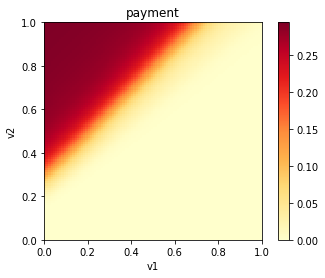

In [13]:
def plot_12_model_payments(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_payments = output_payments.view(xlen, ylen)
    f, (ax1) = plt.subplots(1, 1)
    im1 = ax1.imshow(output_item1_payments.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1])
    ax1.set_title('payment')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    f.colorbar(im1)
    f.show()
    
# plot_12_model_payments(model.to(device='cpu'), 0.01, (0,1), (0,1))

In [8]:
def exact_one_1x2_0_1_optimal_mechanism(bids):
    batch_size, n_agents, n_items = bids.shape
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((batch_size, n_agents))
    
    for i in range(batch_size):
        if bids[i, 0, 0] - 1 / 3 > bids[i, 0, 1]:
            allocs[i, 0, 0] = 1.0
            allocs[i, 0, 1] = 0.0
            payments[i] = 1 / 3
        else:
            allocs[i, 0, 0] = 0.0
            allocs[i, 0, 1] = 1.0
            payments[i] = 0.0
    return allocs, payments

In [31]:
opt_alloc, opt_payments = exact_one_1x2_0_1_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.0687)

In [ ]:
# def optimize_misreports_grad_descent(model, current_valuations, current_misreports, misreport_iter=10, lr=1e-1):
#     # misreports are same size as valuations and start at same place

#     current_misreports.requires_grad_(True)

#     for i in range(misreport_iter):
#         model.zero_grad()  # TODO move this where it ought to be
#         agent_utils = utils.tiled_misreport_util(current_misreports, current_valuations, model)

#         (misreports_grad,) = torch.autograd.grad(agent_utils.sum(), current_misreports)

#         with torch.no_grad():
#             print(utils.tiled_misreport_util(current_misreports, current_valuations, model), misreports_grad)
#             current_misreports += lr * misreports_grad
#             model.clamp_op(current_misreports)

#     return current_misreports

In [ ]:
# sample_bid = torch.tensor([[[.4, .3]]])
# curr_misreports = sample_bid.clone().detach()
# curr_misreports.requires_grad_(True)
# optimize_misreports_grad_descent(model, sample_bid, curr_misreports, 25, .1)

In [ ]:
# sample_bid = torch.tensor([[[.4, .6]]])
# curr_misreports = sample_bid.clone().detach()
# curr_misreports.requires_grad_(True)
# utils.optimize_misreports(model, sample_bid, curr_misreports, 25, .1)

In [ ]:
# print(model(curr_misreports))
# utils.tiled_misreport_util(curr_misreports, sample_bid, model)

In [ ]:
# allocs, pay = model(sample_bid)
# print(allocs, pay)
# utils.calc_agent_util(sample_bid, allocs, pay)

In [ ]:
# tiled_misreports = utils.create_combined_misreports(curr_misreports, sample_bid)

In [ ]:
# agent_idx = list(range(1))
# flatbatch_tiled_misreports = tiled_misreports.view(-1, 1, 2)
# allocations, payments = model(flatbatch_tiled_misreports)
# reshaped_payments = payments.view(
#     -1, 1, 1
# )  # TODO verify this puts things back to the right place
# reshaped_allocations = allocations.view(-1, 1, 1, 2)
# # slice out or mask out agent's payments and allocations
# agent_payments = reshaped_payments[:, agent_idx, agent_idx]
# agent_allocations = reshaped_allocations[:, agent_idx, agent_idx, :]

In [ ]:
# agent_utils = utils.calc_agent_util(sample_bid, agent_allocations, agent_payments) 
# agent_utils

In [19]:
from tqdm import tqdm
from double_net import utils_misreport as utils
def test_loop_random_start(model, loader, args, random_starts, device='cpu'):
    # regrets and payments are 2d: n_samples x n_agents; unfairs is 1d: n_samples.
    test_regrets = torch.Tensor().to(device)
    test_payments = torch.Tensor().to(device)

    for i, batch in tqdm(enumerate(loader)):
        batch = batch.to(device)
        allocs, payments = model(batch)
        truthful_util = utils.calc_agent_util(batch, allocs, payments)
        
        max_regrets = torch.zeros(truthful_util.shape).to(device=device)
        for c in range(len(random_starts)):
            misreport_batch = random_starts[c].clone().detach()
            utils.optimize_misreports(model, batch, misreport_batch,
                                  misreport_iter=args.test_misreport_iter, lr=args.misreport_lr)
            misreport_util = utils.tiled_misreport_util(misreport_batch, batch, model)

            regrets = misreport_util - truthful_util
            positive_regrets = torch.clamp_min(regrets, 0)
            max_regrets = torch.max(max_regrets, positive_regrets)

        # Record entire test data
        test_regrets = torch.cat((test_regrets, max_regrets), dim=0)
        test_payments = torch.cat((test_payments, payments), dim=0)

    mean_regret = test_regrets.sum(dim=1).mean(dim=0).item()
    # mean_sq_regret = (test_regrets ** 2).sum(dim=1).mean(dim=0).item()
    # regret_var = max(mean_sq_regret - mean_regret ** 2, 0)
    result = {
        "payment_mean": test_payments.sum(dim=1).mean(dim=0).item(),
        # "regret_std": regret_var ** .5,
        "regret_mean": mean_regret,
        "regret_max": test_regrets.sum(dim=1).max().item(),
    }
    # for i in range(model.n_agents):
    #     agent_regrets = test_regrets[:, i]
    #     result[f"regret_agt{i}_std"] = (((agent_regrets ** 2).mean() - agent_regrets.mean() ** 2) ** .5).item()
    #     result[f"regret_agt{i}_mean"] = agent_regrets.mean().item()
    return result

In [30]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 20
model.sinkhorn_epsilon = 5e-2
test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
random_starts = [test_data]
for i in range(10):
    random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result


0it [00:00, ?it/s]
1it [03:27, 207.35s/it]

CPU times: user 3min 24s, sys: 407 ms, total: 3min 24s
Wall time: 3min 27s


{'payment_mean': 0.07059674710035324,
 'regret_mean': 0.0014067234005779028,
 'regret_max': 0.00953054428100586}

In [32]:
torch.save(test_data, 'exact_1x2_test_data')

In [ ]:
# item_ranges = ds.preset_valuation_range(2, 4, "")
# train_data = ds.generate_dataset_nxk(2, 4, 2, item_ranges)
# train_data

In [ ]:
# agent_idx = list(range(2))
# allocations, payments = model(train_data)
# agent_utils = utils.calc_agent_util(train_data, allocations, payments) 
# agent_utils

In [ ]:
# allocations, payments

In [ ]:
# model = DoubleNet.load('./exact_one_2x4_0_1_')

In [ ]:
# bids = torch.tensor([[[.0, .0, .0, 1.],
#                      [1.0, .0, .0, .0]]])
# model.sinkhorn_epsilon = 1e-2
# model.sinkhorn_rounds = 20
# model(bids)

In [12]:
filename_prefix = 'exact_one_1x2_0_1_'
model.save(filename_prefix)

In [13]:
torch.save(model.payment_net.state_dict(), filename_prefix + 'pay_net.pytorch')
torch.save(model.alloc_head.state_dict(), filename_prefix + 'alloc_head.pytorch')

In [14]:
import pickle
with open(filename_prefix + 'doublenet_classvariables.pickle', 'rb') as f:
            params_dict = pickle.load(f)

result = DoubleNet(
    params_dict['n_agents'],
    params_dict['n_items'],
    params_dict['item_ranges'],
    params_dict['sinkhorn_epsilon'],
    params_dict['sinkhorn_rounds'],
    params_dict['marginal_choice'],
).to(device=device)
result.neural_net.load_state_dict(torch.load(filename_prefix + 'doublenet.pytorch'))
result.payment_net.load_state_dict(torch.load(filename_prefix + 'pay_net.pytorch'))
result.alloc_head.load_state_dict(torch.load(filename_prefix + 'alloc_head.pytorch'))

<All keys matched successfully>

In [17]:
result(torch.tensor([[[1., 0.]]]).to(device=device))

(tensor([[[0.9755, 0.0021]]], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([[0.3819]], device='cuda:0', grad_fn=<MulBackward0>))